# Using `nnx.view`
This guide covers how to use the `nnx.view` function. This function is useful for handling state in layers like `Dropout`, which behave differently in training and evaluation. Similar to `.view` for numpy arrays, `nnx.view` allows you to set modes of the model while still sharing the same data. For a quick intro to how this method works, refer to the following example:

In [1]:
from flax import nnx

# example model with different train/eval behavior
rngs = nnx.Rngs(0)
model = nnx.Sequential(nnx.Linear(2, 4, rngs=rngs), nnx.BatchNorm(4, rngs=rngs), nnx.Dropout(0.1))

# set train and eval modes
train_model = nnx.view(model, deterministic=False, use_running_average=False)
eval_model = nnx.view(model, deterministic=True, use_running_average=True)

# Can see deterministic is different between train_model and eval_model
assert train_model.layers[2].deterministic == False
assert eval_model.layers[2].deterministic == True

# Weights are shared between the models
assert train_model.layers[0].kernel is eval_model.layers[0].kernel

# Print information about kwargs for nnx.view with nnx.view_info
print(nnx.view_info(model))

BatchNorm:
  use_running_average: bool | None = None
    if True, the stored batch statistics will be
    used instead of computing the batch statistics on the input.
Dropout:
  deterministic: bool | None = None
    if True, disables dropout masking.


## Motivation

Some layers in ML inherently involve state. Consider for example the `nnx.Dropout` layer, which behaves differently during training and evaluation. In these different scenarios, we need a simple way to ensure that the model behaves as intended to avoid silent bugs. A common pattern for doing this is to have a single `model` and use a method like `.train()` before running training code. This requires that the programmer remembers to call these functions in many places in the code and can make the code less readable. Moreover, it can be cumbersome to trace through someone else's code trying to infer the state of a model. 

An alternative to this pattern is to declare the different model states at the beginning of the code. The `nnx.view` method lets you apply multiple model configurations at the beginning of your code and then just use these later without having to call functions like `.train()` or `.eval()`. We demonstrate this with a simple example below.

In [2]:
import jax
import optax
import matplotlib.pyplot as plt

in_dim, hidden_dim, out_dim = 16, 32, 2

class MyModel(nnx.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int, dropout_rate: float, *, rngs: nnx.Rngs):
        self.lin1 = nnx.Linear(in_dim, hidden_dim, rngs=rngs)
        self.do = nnx.Dropout(dropout_rate)
        self.bn = nnx.BatchNorm(hidden_dim, rngs=rngs)
        self.lin2 = nnx.Linear(hidden_dim, out_dim, rngs=rngs)
    
    def __call__(self, x, *, rngs):
        x = self.lin1(x)
        x = self.bn(x)
        x = nnx.relu(self.do(x, rngs=rngs))
        x = self.lin2(x)
        return x

Lets take a look at the model to see what is going on.

In [3]:
# can display to inspect state
model = MyModel(in_dim, hidden_dim, out_dim, 0.1, rngs=nnx.Rngs(0))
nnx.display(model)

# can assert to inspect state
assert model.do.deterministic == False

From the model display, we can see that `Dropout` has `deterministic == False`, suggesting that the model is in training mode. In order to know this, we had to display the model and/or know that `Dropout` is set to training mode by default. It is not clear what state the model is in just by looking at the code without additional inspection. We instead want to be very explicit about what state the model is in. 

This is where `nnx.view` comes in. This function updates the modes for each submodule of a neural network based on the kwargs passed into the function. The underlying model weights are then shared between different views. We set up a training and evaluation version of the model below.

In [4]:
train_model = nnx.view(model, deterministic=False)
eval_model = nnx.view(model, deterministic=True)

# weights are references to the same data
assert train_model.lin1.kernel[...] is eval_model.lin1.kernel[...]

# Dropout.deterministic is different in each model
assert train_model.do.deterministic is False
assert eval_model.do.deterministic is True

Lets see what implications this has for our code design. We set up some simple training and evaluation functions below.

In [5]:
ndata, batch_size, total_epochs, lr = 2048, 32, 100, 1e-3
x = jax.random.normal(jax.random.key(0), (ndata, in_dim))
y = jax.random.normal(jax.random.key(0), (ndata, out_dim))

@nnx.jit
def train_step(model, optimizer, x, y, rngs):
  def loss_fn(model):
    y_pred = model(x, rngs=rngs)
    return ((y_pred - y) ** 2).mean()

  loss, grads = nnx.value_and_grad(loss_fn)(model)
  optimizer.update(model, grads)
  return loss

@nnx.jit
def eval_step(model, x, y):
   return ((model(x, rngs=None) - y) ** 2).mean()

## Example with `nnx.view`

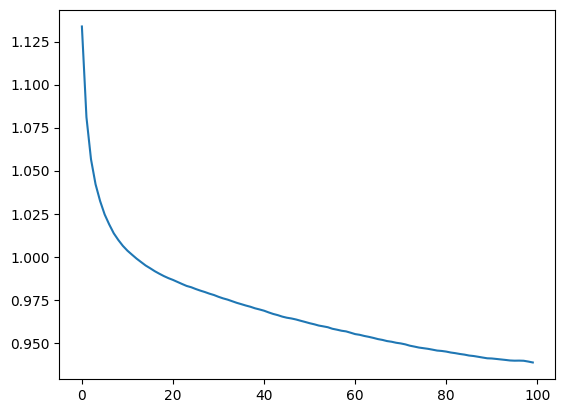

In [6]:
model = MyModel(in_dim, hidden_dim, out_dim, 0.1, rngs=nnx.Rngs(0))
train_model = nnx.view(model, deterministic=False) # create training view
eval_model = nnx.view(model, deterministic=True) # create evaluation view
optimizer = nnx.Optimizer(model, optax.adam(lr), wrt=nnx.Param)
key = jax.random.key(0)

eval_results = [None] * total_epochs
for epoch in range(total_epochs):
    for i in range(ndata // batch_size):
        sl = slice(i*batch_size,(i+1)*batch_size)
        key, subkey = jax.random.split(key)
        train_step(train_model, optimizer, x[sl], y[sl], subkey) # use train_model

    eval_results[epoch] = eval_step(eval_model, x, y) # use eval_model
plt.plot(eval_results)
plt.show()

## Example with Old API

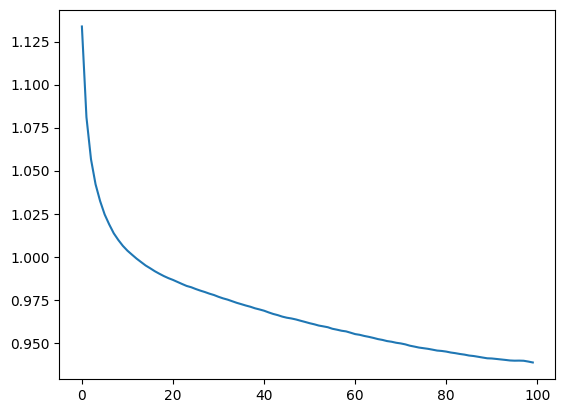

In [7]:
model = MyModel(in_dim, hidden_dim, out_dim, 0.1, rngs=nnx.Rngs(0))
optimizer = nnx.Optimizer(model, optax.adam(lr), wrt=nnx.Param)
key = jax.random.key(0)

eval_results = [None] * total_epochs
for epoch in range(total_epochs):
    model.set_attributes(deterministic=False) # set to train mode
    for i in range(ndata // batch_size):
        sl = slice(i*batch_size,(i+1)*batch_size)
        key, subkey = jax.random.split(key)
        train_step(model, optimizer, x[sl], y[sl], subkey)

    model.set_attributes(deterministic=True) # set to eval mode
    eval_results[epoch] = eval_step(model, x, y)
plt.plot(eval_results)
plt.show()

## Getting information with `nnx.view_info`
To see more information about the options for `nnx.view`, we can use the `nnx.view_info` function to display information about the arguments. This will display each submodule which contains a `set_view` method. It also provides information about the keyword arguments accepted by each submodule, including type information, default values, and docstring descriptions.

In [8]:
print(nnx.view_info(model))

BatchNorm:
  use_running_average: bool | None = None
    if True, the stored batch statistics will be
    used instead of computing the batch statistics on the input.
Dropout:
  deterministic: bool | None = None
    if True, disables dropout masking.


## Writing modules compatible with `nnx.view`
To implement a module that is compatible with `nnx.view` you just need do define a `set_view` class method. This method should
1. Include input kwargs, type annotations, and a default value of `None`.
2. Only update the mode if the kwarg is not `None`. 
3. Include input `**kwargs` for additional keyword arguments used in `nnx.view`. These should not be used by `set_view`.
4. Include a google-style docstring (for parsing with `nnx.view_info`).
5. Return kwargs for identifying unused kwargs.

This will look like
```python
class MyLayer(nnx.Module):
    ...

    def set_view(self, kwarg1: type1 = default1, ..., kwargN: typeN = defaultN, **kwargs) -> dict:
        """Module docstring following Google-style docstrings"""
        # logic to update the mode
        return kwargs
```

Consider the following example

In [9]:
class PrintLayer(nnx.Module):
    def __init__(self, msg: str, *, rngs: nnx.Rngs):
        self.print_msg = None
        self.msg = msg

    def __call__(self, *args, **kwargs):
        if self.print_msg:
            print(self.msg)
    
    def set_view(self, print_msg: bool | None = None, **kwargs) -> dict:
        """Example set_view docstring. This follows Google style docstrings.

        Args:
          print_msg: bool indicating if a message should be printed.
            If True, the `__call__` method prints the message. 
        """
        if print_msg is not None:
            self.print_msg = print_msg
        return kwargs
    
l = PrintLayer("Hello, World!", rngs=nnx.Rngs(0))
l_print = nnx.view(l, print_msg=True)

In [10]:
# print the default view
print(l)

# Nothing printed from call method
l()

PrintLayer(
  print_msg=None,
  msg='Hello, World!'
)


In [11]:
# print the l_print view
print(l_print)

# Prints "Hello, World!" from the call method
l_print()

PrintLayer(
  msg='Hello, World!',
  print_msg=True
)
Hello, World!


In [12]:
# Display the information for nnx.view
print(nnx.view_info(l))

PrintLayer:
  print_msg: bool | None = None
    bool indicating if a message should be printed.
    If True, the `__call__` method prints the message. 
